In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity
import matplotlib.image as mpimg

from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial import distance

from math import sin, cos, sqrt, atan2, radians

## UTS Big Data Analysis

Nama: Made Yoga Mahardika <br>
NRP: 26416083 <br>
<ul>
    <li>Ujian bersifat <b>Open All & tidak berkomunikasi dengan sesama!</b>. </li>
    <li>Waktu Ujian: 2 Jam 30 Menit (150 Menit)</li>
</ul>
<br>Silahkan dengan informasi yang ada di internet kalian memberikan kesimpulan untuk analisa kalian.

## Soal Analysis

Rumah Sakit Zetra, merupakan rumah sakit ternama yang menangani banyak pasien. Rumah sakit ini mendekteksi ada peningkatan jumlah penyakit pada daerah mereka. Penyakit itu adalah penyakit yang disebabkan oleh virus West Nile. Para peneliti rumah sakit ini kemudian membuat beberapa perangkap untuk menangkap nyamuk yang menjadi vector persebaran virus. Nyamuk - nyamuk yang sudah terperangkap kemudian dianalisa untuk dicari tau apakah nyamuk tersebut membawa Virus West Nile. 

Data dari tempat perangkap nyamuk dan keberadaan Virus West Nile dapat kalian lihat di <b>train.csv</b>. Anda sebagai Data Scientist diundang untuk ikut hadir dalam rapat penanggulangan penyakit tersebut. Karena penyakit sudah tersebar ke beberapa daerah dan resource yang terbatas, buatlah sebuah analysis untuk <b>mencari daerah - daerah yang harus diprioritaskan dan seberapa besar radius daerah yang harus ditanggulangi.</b>

Anda harus memberikan visualisasi titik titik pusat persebaran penyakit, beserta radius yang daerah yang sebaiknya ditanggulangi. Kemudian beri prioritas daerah mana yang harus ditanggulangi lebih! Anda mendapatkan tools yang dapat digunakan untuk menggambarkan titik titik persebaran beserta radius yang harus dicapai.

<ul>
    <li>Data: <b>train.csv</b></li>
    <li>
        Tools: <b>Anda dapat menggunakan object helper untuk membantu pengerjaan project anda!</b>
        <ul>
            <li>draw_map_only() : Untuk menggambar peta lokasi kejadian</li>
            <li>draw_heatmap()  : Untuk menggambar heatmap persebaran penyakit.</li>
            <li>draw_heatmap(list centroid, list radius)  : Untuk menggambar heatmap, beserta titik titik yang menjadi pusar persebaran penyakit dan radius per titiknya</li>
            <li>long_lat_to_km(long1, lat1, long2, lat2) : Untuk melakukan konversi jarak 2 titik dalam longitude dan latitude kedalam km!</li>
        </ul>    
    <li>
        Penilaian:
        <ul>
            <li>(20) Dapat membagi daerah daerah persebaran penyakit</li>
            <li>(10) Dapat melakukan optimasi metode yang digunakan (meoptimalkan hasil dengan setting parameter)</li>
            <li>(10) Dapat memberi radius setiap titik yang ada dengan alasan yang jelas</li>
            <li>(10) Dapat memberi prioritas daerah mana yang harus ditanggulangi dahulu dengan alasan yang jelas</li>
        </ul>
    </li>
</ul>

### Untuk mencari radius pada kelompok data anda dapat menggunakan rumus dibawah ini.
<b>Distance Metric yang digunakan: Euclidean Distance</b>


\begin{equation*}
radius = max_{i=0}^n distance(centroid, point_i)
\end{equation*}

In [2]:
class Helper:
    
    mapdata = np.loadtxt("dataset/mapdata_copyright_openstreetmap_contributors.txt")
    traps = pd.read_csv('dataset/train.csv')[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]
    img = mpimg.imread('dataset/map.png')
    
    aspect = None
    lon_lat_box = None
    
    def __init__(self):
        self.aspect = self.mapdata.shape[0] * 1.0 / self.mapdata.shape[1]
        self.lon_lat_box = (-88, -87.5, 41.6, 42.1)
    
    def long_lat_to_km(self, long1, lat1, long2, lat2):
        R = 6373.0

        lat1 = radians(lat1)
        lon1 = radians(long1)
        lat2 = radians(lat2)
        lon2 = radians(long2)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        distance = R * c
        return distance
    
    def draw_map_only(self):
        plt.figure(figsize=(10,14))
        plt.imshow(self.img, 
           cmap=plt.get_cmap('gray'), 
           extent=self.lon_lat_box, 
           aspect=self.aspect)
    
    def draw_heatmap(self, locations=[], radius=[]):
        fig, ax = plt.subplots(figsize=(10,14))
        alpha_cm = plt.cm.Reds
        alpha_cm._init()
        alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]

        sigthings = self.traps[self.traps['WnvPresent'] > 0]
        sigthings = sigthings.groupby(['Date', 'Trap','Longitude', 'Latitude']).max()['WnvPresent'].reset_index()
        X = sigthings[['Longitude', 'Latitude']].values
        kd = KernelDensity(bandwidth=0.02)
        kd.fit(X)

        xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
        gridpoints = np.array([xv.ravel(),yv.ravel()]).T
        zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
        
        ax.imshow(self.img, 
                   cmap=plt.get_cmap('gray'), 
                   extent=self.lon_lat_box, 
                   aspect=self.aspect)
        ax.imshow(zv, 
                   origin='lower', 
                   cmap=alpha_cm, 
                   extent=self.lon_lat_box, 
                   aspect=self.aspect)
        
        if not (len(locations) == 0):
            ax.scatter(locations[:,0], locations[:,1], marker='x', color='k')
            if len(locations) == len(radius):
                co = 0
                for location in list(locations):
                    c = plt.Circle((location[0], location[1]), radius[co], color='orange', alpha=0.3)
                    ax.add_artist(c)
                    co += 1

### Fungsi draw_heatmap(), untuk menggambarkan persebaran penyakit

Axis X adalah Longitude dan Axis Y adalah Latitude

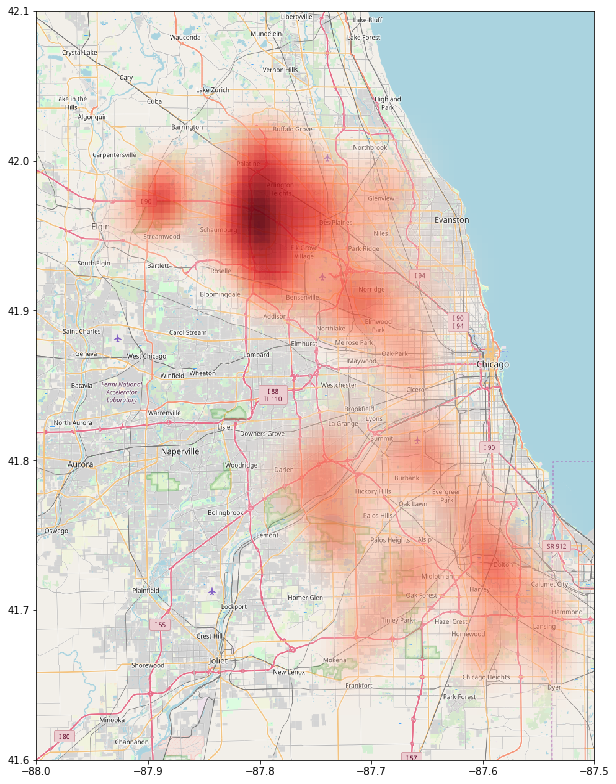

In [3]:
helper = Helper()
helper.draw_heatmap()

### Examples!

### Penggunaan fungsi draw_heatmap(), dengan parameter centroids dan radius!

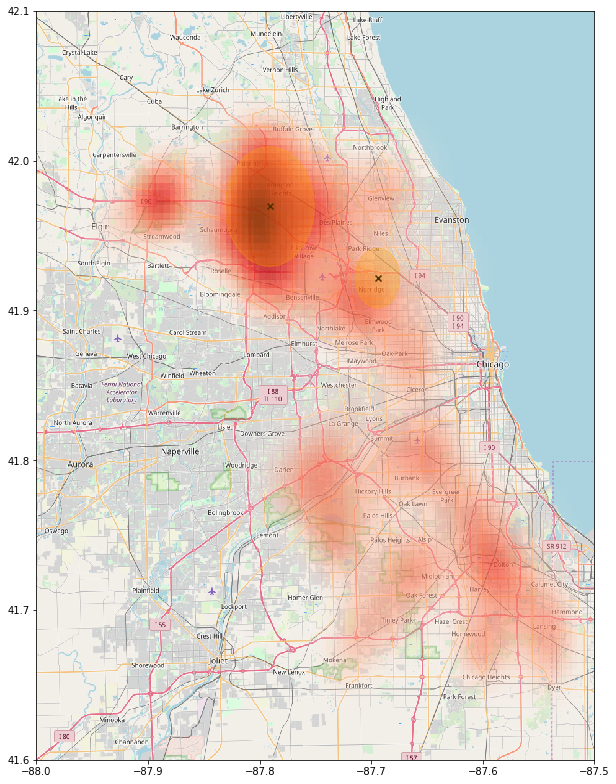

In [4]:
centroids = np.array([
    [-87.69426273,  41.92157199],
    [-87.79101079,  41.96933146]
])

radius = [0.02, 0.04]

helper.draw_heatmap(centroids, radius)

### Penggunaan fungsi long_lat_to_km(), Untuk mencari jarak dalam km dari 2 titik longitude dan latitude!

In [5]:
distance_in_km = helper.long_lat_to_km(21.0122287, 52.2296756, 16.9251681, 52.406374)
distance_in_km

278.54558935106695

### Start Analyzing Here!

In [6]:
df = pd.read_csv('dataset/train.csv')
df.head()

Date                 Species  Trap   Latitude  Longitude  \
0  2007-05-29  CULEX PIPIENS/RESTUANS  T002  41.954690 -87.800991   
1  2007-05-29          CULEX RESTUANS  T002  41.954690 -87.800991   
2  2007-05-29          CULEX RESTUANS  T007  41.994991 -87.769279   
3  2007-05-29  CULEX PIPIENS/RESTUANS  T015  41.974089 -87.824812   
4  2007-05-29          CULEX RESTUANS  T015  41.974089 -87.824812   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

In [7]:
wnv_df = df[df['WnvPresent'] == 1]
wnv_df.head()

Date                 Species  Trap   Latitude  Longitude  \
553  2007-07-18  CULEX PIPIENS/RESTUANS  T215  41.686398 -87.531635   
603  2007-07-25  CULEX PIPIENS/RESTUANS  T115  41.673408 -87.599862   
611  2007-07-25  CULEX PIPIENS/RESTUANS  T115  41.673408 -87.599862   
618  2007-07-25           CULEX PIPIENS  T115  41.673408 -87.599862   
660  2007-07-25           CULEX PIPIENS  T115  41.673408 -87.599862   

     NumMosquitos  WnvPresent  
553            50           1  
603            50           1  
611            50           1  
618            50           1  
660            50           1

### Terdapat 551 titik Wnv Present

In [8]:
wnv_df.shape

(551, 7)

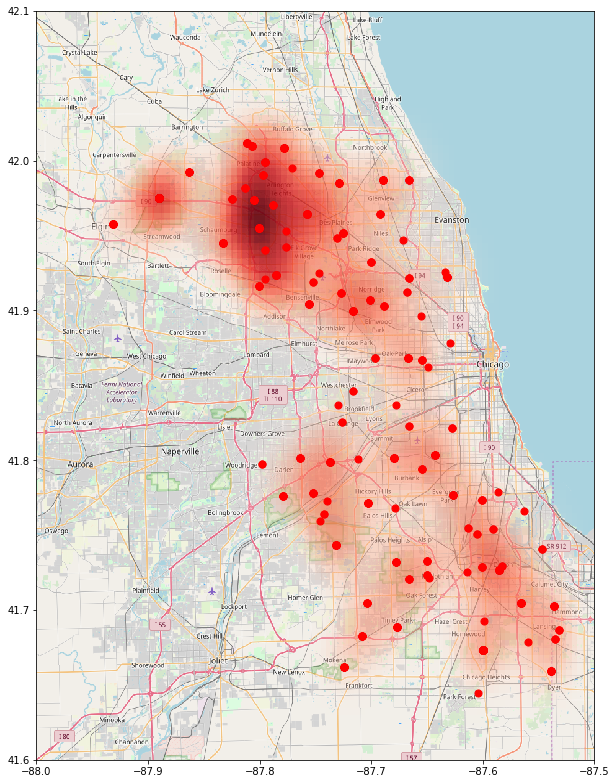

In [9]:
helper.draw_heatmap()
wnv_model_df = wnv_df.loc[:, ['Longitude', 'Latitude', 'NumMosquitos', 'WnvPresent']]
plt.scatter(
    wnv_model_df.loc[:, 'Longitude'], 
    wnv_model_df.loc[:, 'Latitude'],
    marker='o', color='red',
    s=50
)

# Daerah Daerah Persebaran Penyakit

Pembagian daerah dengan menggunakan metode KMeans dengan n_clusters = 7 <br>
n_clusters 7 hanya intuisi

In [10]:
X = wnv_model_df.iloc[:, :-2]
kmeans_model = KMeans(n_clusters=7)
kmeans_model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [11]:
kmeans_model.labels_

array([2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5, 4, 4, 6, 3, 3, 0, 5, 5, 2, 2,
       2, 2, 4, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 6, 5, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 6, 5, 5, 6, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6,
       3, 5, 6, 4, 3, 3, 3, 3, 3, 3, 5, 5, 0, 5, 5, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 6,
       6, 4, 4, 3, 3, 3, 6, 4, 5, 3, 3, 3, 3, 3, 3, 3, 2, 0, 6, 5, 5, 0,
       0, 0, 0, 5, 5, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 6, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4,
       3, 3, 3, 4, 4, 5, 6, 3, 3, 3, 3, 6, 3, 3, 4, 5, 2, 5, 5, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 6, 6, 6, 3, 5, 0, 4, 5, 4, 4, 4, 5,
       2, 2, 2, 2, 2, 2, 3, 3, 0, 5, 0, 2, 2, 2, 0, 0, 3, 0, 4, 4, 0, 5,
       6, 3, 2, 2, 1, 1, 1, 1, 1, 4, 6, 6, 3, 1, 1, 0, 0, 5, 1, 1, 1, 1,
       1, 3, 3, 1, 1, 1, 1, 4, 5, 2, 1, 1, 1, 1, 1, 1, 1, 3, 6, 5, 1, 1,
       0, 1, 3, 0, 3, 3, 6, 3, 4, 1, 1, 6, 3, 6, 1,

In [12]:
wnv_model_df['cluster'] = kmeans_model.labels_
wnv_model_df.head()

Longitude   Latitude  NumMosquitos  WnvPresent  cluster
553 -87.531635  41.686398            50           1        2
603 -87.599862  41.673408            50           1        2
611 -87.599862  41.673408            50           1        2
618 -87.599862  41.673408            50           1        2
660 -87.599862  41.673408            50           1        2

In [13]:
kmeans_model.cluster_centers_

array([[-87.74247033,  41.77875958],
       [-87.89351841,  41.97393088],
       [-87.57997983,  41.69592221],
       [-87.79454007,  41.96845773],
       [-87.68592813,  41.70089174],
       [-87.65322254,  41.8178157 ],
       [-87.70228419,  41.93686493]])

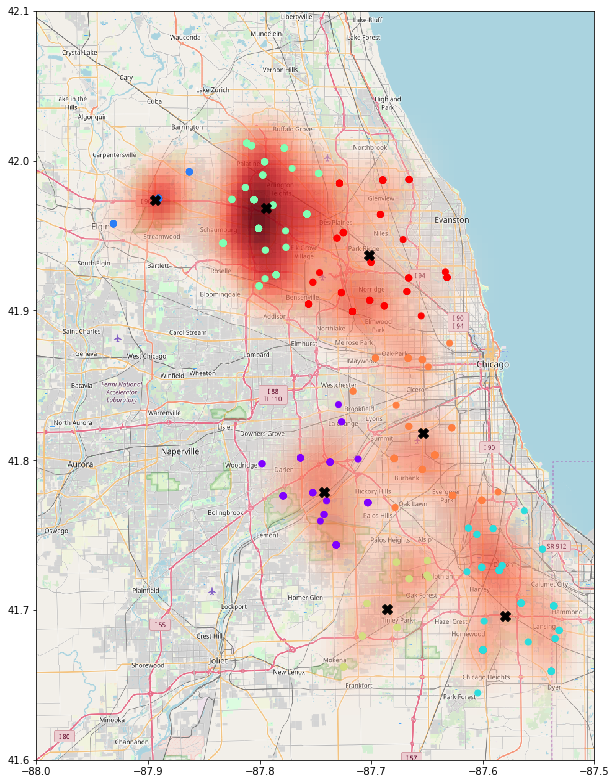

In [14]:
helper.draw_heatmap()

plt.scatter(
    wnv_model_df.loc[:, 'Longitude'], 
    wnv_model_df.loc[:, 'Latitude'], 
    c=kmeans_model.labels_,
    cmap='rainbow'
)

plt.scatter(
    kmeans_model.cluster_centers_[:, 0], 
    kmeans_model.cluster_centers_[:, 1], 
    marker='X', s=100,
    color='black'
)

# Centroid Radius

Radius, jarak antar centroid terhadap titik terjauh dalam cluster centroid tersebut.
\begin{equation*}
radius = max_{i=0}^n euclidean(centroid, point_i)
\end{equation*}

In [15]:
wnv_model_df.head()

Longitude   Latitude  NumMosquitos  WnvPresent  cluster
553 -87.531635  41.686398            50           1        2
603 -87.599862  41.673408            50           1        2
611 -87.599862  41.673408            50           1        2
618 -87.599862  41.673408            50           1        2
660 -87.599862  41.673408            50           1        2

In [16]:
kmeans_model.cluster_centers_

array([[-87.74247033,  41.77875958],
       [-87.89351841,  41.97393088],
       [-87.57997983,  41.69592221],
       [-87.79454007,  41.96845773],
       [-87.68592813,  41.70089174],
       [-87.65322254,  41.8178157 ],
       [-87.70228419,  41.93686493]])

\begin{equation*}
radius = max_{i=0}^n euclidean(centroid, point_i)
\end{equation*}

In [17]:
radius = []
for cluster_index in np.unique(kmeans_model.labels_):
    # select from wnv model where data cluster is cluster_index
    mask = (wnv_model_df['cluster'] == cluster_index)
    masked_data = wnv_model_df[mask]
    
    # get distance of centroid to each member
    centroid = kmeans_model.cluster_centers_[cluster_index]
    distances = []
    for data in masked_data.iterrows():
        point = data[1]['Longitude'], data[1]['Latitude']
        distances.append(distance.euclidean(centroid, point))
    
    # radius is the maximum distance of centroid to each member
    radius.append(max(distances))

radius

[0.05977547096794073,
 0.04080112670091972,
 0.07232803787809271,
 0.052697311616864174,
 0.05484168952062046,
 0.07738171618589675,
 0.07176303639940576]

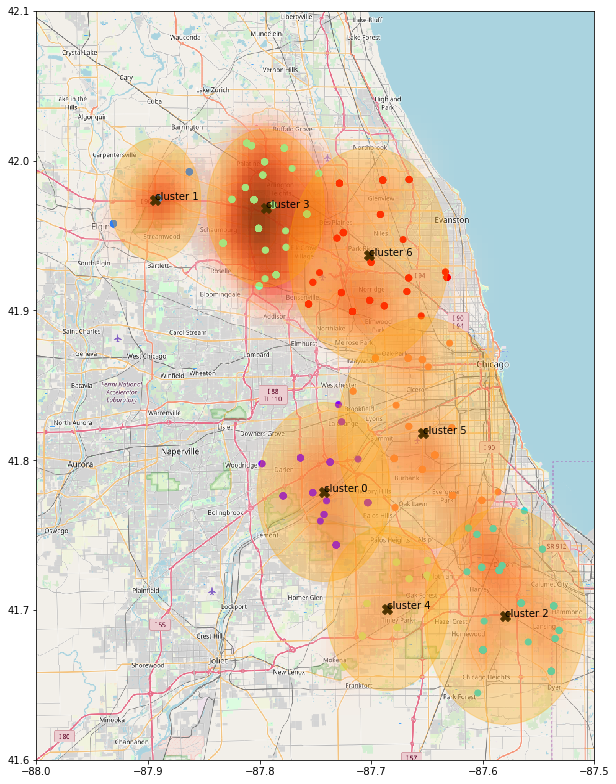

In [18]:
helper.draw_heatmap(kmeans_model.cluster_centers_, radius)

plt.scatter(
    wnv_model_df.loc[:, 'Longitude'], 
    wnv_model_df.loc[:, 'Latitude'], 
    c=kmeans_model.labels_,
    cmap='rainbow'
)

plt.scatter(
    kmeans_model.cluster_centers_[:, 0], 
    kmeans_model.cluster_centers_[:, 1], 
    marker='X',
    s=100,
    color='black'
)

labels = ['cluster ' + str(index) for index in np.unique(kmeans_model.labels_)]
for centroid, label in zip(kmeans_model.cluster_centers_, labels):
    plt.text(centroid[0], centroid[1], label, color='black')

# Prioritas Penanggulangan Daerah

Dengan jumlah nyamuk carrier terbanyak tiap cluster

In [19]:
wnv_model_df.head()

Longitude   Latitude  NumMosquitos  WnvPresent  cluster
553 -87.531635  41.686398            50           1        2
603 -87.599862  41.673408            50           1        2
611 -87.599862  41.673408            50           1        2
618 -87.599862  41.673408            50           1        2
660 -87.599862  41.673408            50           1        2

In [20]:
wnv_model_df.loc[:, ['NumMosquitos', 'cluster']].groupby('cluster').sum().sort_values('NumMosquitos', ascending=False)

NumMosquitos
cluster              
2                4224
3                3116
1                2490
6                1597
4                1169
0                1020
5                 903

# Method Optimization
K-Means & Elbow Method, Optimasi parameter n_clusters / k

In [21]:
distortions = []
inertias_ = []

k_range = range(1, 14)

for k in k_range:
    model = KMeans(n_clusters=k)
    model.fit(X)
    inertias_.append(model.inertia_)
    distortions.append(sum(np.min(distance.cdist(X.values, model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

Text(0.5, 1.0, 'Elbow method using Distortion')

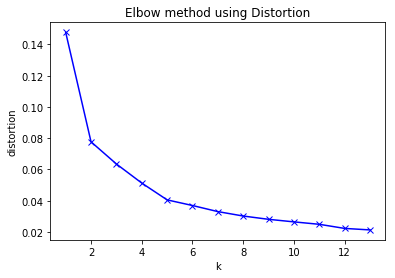

In [22]:
plt.plot(k_range, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('distortion')
plt.title('Elbow method using Distortion')

Text(0.5, 1.0, 'Elbow method using inertia_')

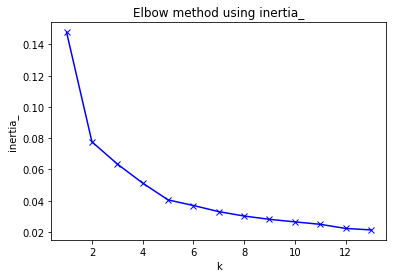

In [23]:
plt.plot(k_range, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia_')
plt.title('Elbow method using inertia_')

### The Optimal Value For K is 5

# Daerah daerah persebaran penyakit (Optimal K)

In [24]:
kmeans_model = KMeans(n_clusters=5)
kmeans_model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [25]:
wnv_model_df['cluster'] = kmeans_model.labels_
wnv_model_df.head()

Longitude   Latitude  NumMosquitos  WnvPresent  cluster
553 -87.531635  41.686398            50           1        2
603 -87.599862  41.673408            50           1        2
611 -87.599862  41.673408            50           1        2
618 -87.599862  41.673408            50           1        2
660 -87.599862  41.673408            50           1        2

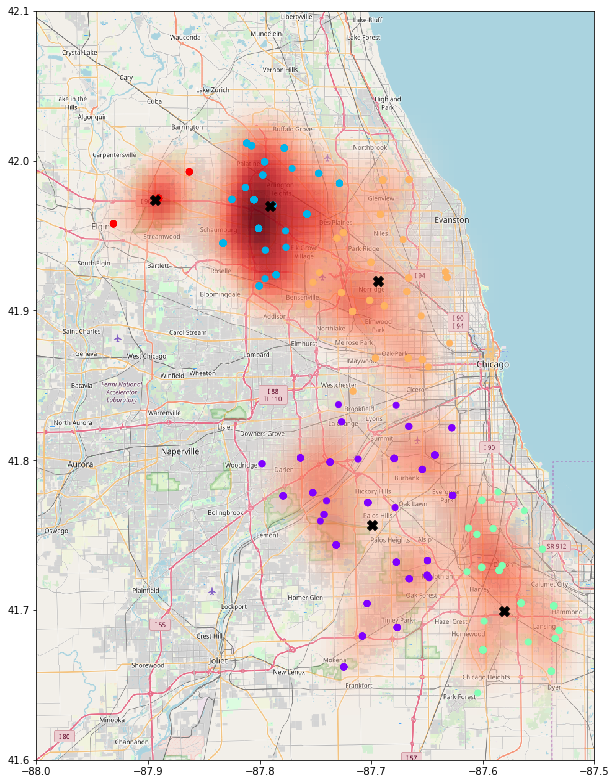

In [26]:
helper.draw_heatmap()

plt.scatter(
    wnv_model_df.loc[:, 'Longitude'], 
    wnv_model_df.loc[:, 'Latitude'], 
    c=kmeans_model.labels_,
    cmap='rainbow'
)

plt.scatter(
    kmeans_model.cluster_centers_[:, 0], 
    kmeans_model.cluster_centers_[:, 1], 
    marker='X', s=100,
    color='black'
)

# Centroid Radius (Optimal K)
\begin{equation*}
radius = max_{i=0}^n euclidean(centroid, point_i)
\end{equation*}

In [42]:
radius = []
radius_in_km = []
for cluster_index in np.unique(kmeans_model.labels_):
    # select from wnv model where data cluster is cluster_index
    mask = (wnv_model_df['cluster'] == cluster_index)
    masked_data = wnv_model_df[mask]
    
    # get distance of centroid to each member
    centroid = kmeans_model.cluster_centers_[cluster_index]
    distances = []
    distances_in_km = []
    for data in masked_data.iterrows():
        point = data[1]['Longitude'], data[1]['Latitude']
        distances.append(distance.euclidean(centroid, point))
        distances_in_km.append(helper.long_lat_to_km(centroid[0], centroid[1], point[0], point[1]))
    
    # radius is the maximum distance of centroid to each member
    radius.append(max(distances))
    radius_in_km.append(max(distances_in_km))

radius, radius_in_km

([0.10662165785404806,
  0.06440615608196337,
  0.0795885382002114,
  0.07647837982176499,
  0.04080112670091972],
 [10.749652043347618,
  5.954718707280006,
  8.842702198279497,
  8.345131461295706,
  3.581396172796982])

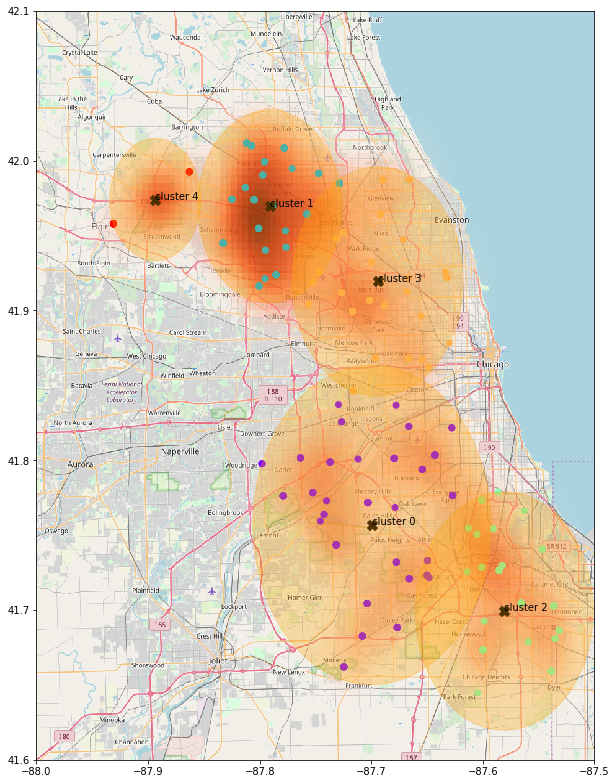

In [28]:
helper.draw_heatmap(kmeans_model.cluster_centers_, radius)

plt.scatter(
    wnv_model_df.loc[:, 'Longitude'], 
    wnv_model_df.loc[:, 'Latitude'], 
    c=kmeans_model.labels_,
    cmap='rainbow'
)

plt.scatter(
    kmeans_model.cluster_centers_[:, 0], 
    kmeans_model.cluster_centers_[:, 1], 
    marker='X',
    s=100,
    color='black'
)

labels = ['cluster ' + str(index) for index in np.unique(kmeans_model.labels_)]
for centroid, label in zip(kmeans_model.cluster_centers_, labels):
    plt.text(centroid[0], centroid[1], label, color='black')

# Prioritas Penanggulangan Daerah (Optimal K)
Dengan jumlah nyamuk carrier terbanyak tiap cluster

In [36]:
priority_df = wnv_model_df.loc[:, ['NumMosquitos', 'cluster']].groupby('cluster').sum().sort_values('NumMosquitos', ascending=False).reset_index()
priority_df

cluster  NumMosquitos
0        2          4261
1        1          3217
2        0          2779
3        4          2490
4        3          1772

In [55]:
wnv_model_df.loc[:, ['NumMosquitos', 'cluster']].groupby('cluster').mean().sort_values('NumMosquitos', ascending=False).reset_index()

cluster  NumMosquitos
0        2     37.377193
1        4     30.365854
2        1     24.557252
3        0     21.053030
4        3     19.260870

In [44]:
for cluster_index in priority_df['cluster']:
    print(cluster_index, kmeans_model.cluster_centers_[cluster_index], radius_in_km[cluster_index])

2 [-87.58076972  41.69936078] 8.842702198279497
1 [-87.79101079  41.96933146] 5.954718707280006
0 [-87.69939142  41.75680645] 10.749652043347618
4 [-87.89351841  41.97393088] 3.581396172796982
3 [-87.69424779  41.9192864 ] 8.345131461295706


In [78]:
def draw_priority():
    helper.draw_heatmap(kmeans_model.cluster_centers_, radius)

    plt.scatter(
        wnv_model_df.loc[:, 'Longitude'], 
        wnv_model_df.loc[:, 'Latitude'], 
        c=kmeans_model.labels_,
        cmap='rainbow'
    )

    plt.scatter(
        kmeans_model.cluster_centers_[:, 0], 
        kmeans_model.cluster_centers_[:, 1], 
        marker='X',
        s=100,
        color='black'
    )

    labels = ['daerah/cluster ' + str(index) for index in np.unique(kmeans_model.labels_)]
    for priority_index, cluster_index in enumerate(priority_df.loc[:, 'cluster']):
        centroid = kmeans_model.cluster_centers_[cluster_index]
        label = labels[cluster_index]# "D{} Priority ".format(cluster_index) + str(priority_index + 1)
        plt.text(centroid[0], centroid[1], label, color='black')

# Extra Analysis

In [58]:
wnv_df.head()

Date                 Species  Trap   Latitude  Longitude  \
553  2007-07-18  CULEX PIPIENS/RESTUANS  T215  41.686398 -87.531635   
603  2007-07-25  CULEX PIPIENS/RESTUANS  T115  41.673408 -87.599862   
611  2007-07-25  CULEX PIPIENS/RESTUANS  T115  41.673408 -87.599862   
618  2007-07-25           CULEX PIPIENS  T115  41.673408 -87.599862   
660  2007-07-25           CULEX PIPIENS  T115  41.673408 -87.599862   

     NumMosquitos  WnvPresent  
553            50           1  
603            50           1  
611            50           1  
618            50           1  
660            50           1

In [61]:
temp = wnv_df.copy()
temp['Date'] = pd.to_datetime(temp.loc[:, 'Date'])

In [63]:
temp['Year'] = temp['Date'].dt.year
temp.head()

Date                 Species  Trap   Latitude  Longitude  \
553 2007-07-18  CULEX PIPIENS/RESTUANS  T215  41.686398 -87.531635   
603 2007-07-25  CULEX PIPIENS/RESTUANS  T115  41.673408 -87.599862   
611 2007-07-25  CULEX PIPIENS/RESTUANS  T115  41.673408 -87.599862   
618 2007-07-25           CULEX PIPIENS  T115  41.673408 -87.599862   
660 2007-07-25           CULEX PIPIENS  T115  41.673408 -87.599862   

     NumMosquitos  WnvPresent  Year  
553            50           1  2007  
603            50           1  2007  
611            50           1  2007  
618            50           1  2007  
660            50           1  2007

In [67]:
yearly_mosq = temp.loc[:, ['Year', 'NumMosquitos']].groupby('Year').sum().reset_index()
yearly_mosq

Year  NumMosquitos
0  2007          6714
1  2009           400
2  2011          1193
3  2013          6212

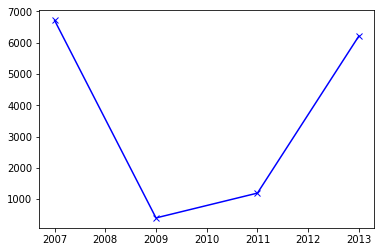

In [69]:
plt.plot(yearly_mosq.iloc[:, 0], yearly_mosq.iloc[:, 1], '-xb')

In [70]:
temp['cluster'] = wnv_model_df['cluster']
temp.head()

Date                 Species  Trap   Latitude  Longitude  \
553 2007-07-18  CULEX PIPIENS/RESTUANS  T215  41.686398 -87.531635   
603 2007-07-25  CULEX PIPIENS/RESTUANS  T115  41.673408 -87.599862   
611 2007-07-25  CULEX PIPIENS/RESTUANS  T115  41.673408 -87.599862   
618 2007-07-25           CULEX PIPIENS  T115  41.673408 -87.599862   
660 2007-07-25           CULEX PIPIENS  T115  41.673408 -87.599862   

     NumMosquitos  WnvPresent  Year  cluster  
553            50           1  2007        2  
603            50           1  2007        2  
611            50           1  2007        2  
618            50           1  2007        2  
660            50           1  2007        2

In [77]:
temp[temp['Year'] == 2009].loc[:, ['NumMosquitos', 'cluster']].groupby('cluster').sum().sort_values('NumMosquitos', ascending=False)

NumMosquitos
cluster              
4                 161
0                 117
1                  77
3                  40
2                   5

In [75]:
temp[temp['Year'] == 2011].loc[:, ['NumMosquitos', 'cluster']].groupby('cluster').sum().sort_values('NumMosquitos', ascending=False)

NumMosquitos
cluster              
4                 550
1                 347
0                 169
2                  64
3                  63

In [73]:
temp[temp['Year'] == 2013].loc[:, ['NumMosquitos', 'cluster']].groupby('cluster').sum().sort_values('NumMosquitos', ascending=False)

NumMosquitos
cluster              
4                1779
1                1435
3                1418
0                1149
2                 431

In [76]:
temp[temp['Year'] == 2011].loc[:, ['NumMosquitos', 'cluster']].groupby('cluster').mean().sort_values('NumMosquitos', ascending=False)

NumMosquitos
cluster              
1           24.785714
2           21.333333
4           21.153846
0           21.125000
3           10.500000

In [74]:
temp[temp['Year'] == 2013].loc[:, ['NumMosquitos', 'cluster']].groupby('cluster').mean().sort_values('NumMosquitos', ascending=False)

NumMosquitos
cluster              
4           34.882353
1           27.075472
3           24.033898
2           23.944444
0           19.810345

### Reasoning Here!
Pada section ini, berikan alasan kalian, apa yang sebaiknya dilakukan oleh rumah sakit untuk menanggulangi persebaran penyakit West Nile tersebut!

Rumah Sakit sebaik nya berkumpul di titik centroid, dan mulai mengarahkan pembasmi nyamuk untuk memusnahkan nyamuk-nyamuk yang terdapat di sekitar titik tersebut. 

### Prioritas Hasil dari Extra Analisis
Dapat dilihat pada Daerah/Cluster ke 3, selama 2 tahun terakhir angka Mosquito carrier naik hingga 22x lipat, percepatan naik angka sangatlah besar.
Oleh karena itu, Daerah 3 haruslah menjadi prioritas utama penanggulangan. agar tidak terjadinya kenaikan angka yang signifikan pada daerah tersebut.

***Prioritas***: 

- **Daerah/Cluster 3**
    - sejauh 8.345Kilometer disekitarnya
    
    
- **Daerah/Cluster 4**
    - sejauh 3.581Kilometer disekitarnya
    
    
- **Daerah/Cluster 1**
    - sejauh 5.954Kilometer disekitarnya
    
    
- **Daerah/Cluster 0**
    - sejauh 10.749Kilometer disekitarnya
    
    
- **Daerah/Cluster 2**
    - Sejauh 8.842Kilometer disekitarnya
    
### Daerah di titik tengah dengan prioritas berikut:
- **Daerah/Cluster 2 titik [-87.58076972  41.69936078]** <br>
    - Sejauh 8.842Kilometer disekitarnya
    - Jumlah nyamuk tercatat 4261 ekor.


- **Daerah/Cluster 1 titik [-87.79101079  41.96933146]** <br>
    - sejauh 5.954Kilometer disekitarnya
    - Jumlah nyamuk tercatat 3217 ekor. 


- **Daerah/Cluster 0 titik [-87.69939142  41.75680645]** <br>
    - sejauh 10.749Kilometer disekitarnya
    - Jumlah nyamuk tercatat 2779 ekor. 


- **Daerah/Cluster 4 titik [-87.89351841  41.97393088]** <br>
    - sejauh 3.581Kilometer disekitarnya
    - Jumlah nyamuk tercatat 2490 ekor. 


- **Daerah/Cluster 3 titik [-87.69424779  41.9192864 ]** <br>
    - sejauh 8.345Kilometer disekitarnya
    - Jumlah nyamuk tercatat 1772 ekor. 

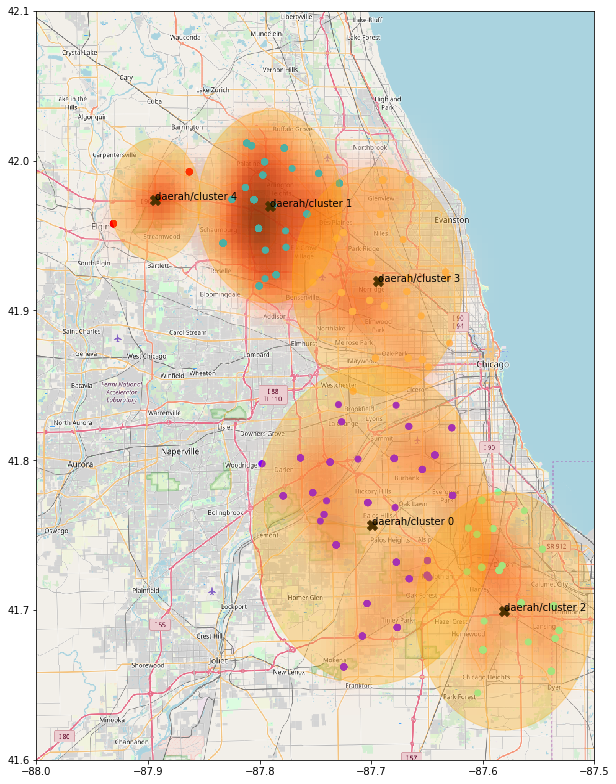

In [79]:
draw_priority()